<a href="https://colab.research.google.com/github/aditya-siraskar/practice/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div align="center">Olist Brazilian E-Commerce: Predicting Customer Satisfaction</div>

### **Subject:** Applied Machine Learning (AML)

### **Goal:** To build a machine learning model that can predict whether a new customer will be 'Satisfied' (4-5 stars) or 'Not Satisfied' (1-3 stars) based on their order information.

### Project Outline

* **Phase 1: Data Loading and Definition:** Load all 9 datasets.
* **Phase 2: Data Merging and Aggregation:** Combine the datasets into a single master table.
* **Phase 3: Exploratory Data Analysis (EDA):** Analyze the target variable and find key relationships.
* **Phase 4: Feature Engineering:** Create new, powerful features from the existing data.
* **Phase 5: Pre-processing:** Prepare the data for modeling (imputation, scaling, encoding).
* **Phase 6: Model Implementation:** Train and evaluate 10 different classification models.
* **Phase 7: Hyperparameter Tuning & Final Evaluation:** Tune the best model and provide business insights.

In [ ]:
# --- Import Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set default styles
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

## --- PHASE 1: DATA LOADING AND DEFINITION ---

In [ ]:
print("Phase 1: Loading all 9 CSV files...")

# Load all datasets
customers = pd.read_csv('dataset/olist_customers_dataset.csv')
geolocation = pd.read_csv('dataset/olist_geolocation_dataset.csv') # Will not be used directly to merge
order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
payments = pd.read_csv('dataset/olist_order_payments_dataset.csv')
reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
orders = pd.read_csv('dataset/olist_orders_dataset.csv')
products = pd.read_csv('dataset/olist_products_dataset.csv')
sellers = pd.read_csv('dataset/olist_sellers_dataset.csv')
translation = pd.read_csv('dataset/product_category_name_translation.csv')

print("All files loaded successfully.")

# Check for missing values in key tables
print("\nMissing values in 'orders':")
print(orders.isnull().sum())

print("\nMissing values in 'reviews':")
print(reviews.isnull().sum())

Phase 1: Loading all 9 CSV files...
All files loaded successfully.

Missing values in 'orders':
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Missing values in 'reviews':
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


### Phase 1 - Inferences

**Observation:**
* All 9 datasets have been loaded into memory.
* The `orders` dataset has significant missing values in `order_approved_at`, `order_delivered_carrier_date`, and `order_delivered_customer_date`. This is expected, as it corresponds to orders that were created but not approved, or are still in transit.
* The `reviews` dataset has many missing `review_comment_title` and `review_comment_message`. This is also expected, as most users just leave a score.

**Next Step:** The data is relational and spread across multiple files. We must create a single 'master' table, with **one row per order**, to make it usable for machine learning. This will require careful merging and aggregation.

## --- PHASE 2: DATA MERGING AND AGGREGATION ---

In [ ]:
# 2a. Aggregate Payments Data
# An order can have multiple payment methods (e.g., voucher + credit card).
# We will aggregate this to one row per order.

# We only care about voucher and credit_card types for this aggregation
payments_agg = payments.loc[payments['payment_type'].isin(['voucher', 'credit_card'])]

# Get the most common payment type per order
payments_type = payments_agg.loc[payments_agg.groupby('order_id')['payment_sequential'].idxmax()][['order_id', 'payment_type']]

# Sum up payment values and get max installments
payments_agg = payments_agg.groupby('order_id')[['payment_installments', 'payment_value']].agg(
    {'payment_installments': 'max', 'payment_value': 'sum'}
).reset_index()

# Merge the common type back
payments_agg = payments_agg.merge(payments_type, on='order_id', how='left')

print("Payment data aggregated.")
print(payments_agg.head())

Payment data aggregated.
                           order_id  payment_installments  payment_value  \
0  00010242fe8c5a6d1ba2dd792cb16214                     2          72.19   
1  00018f77f2f0320c557190d7a144bdd3                     3         259.83   
2  000229ec398224ef6ca0657da4fc703e                     5         216.87   
3  00024acbcdf0a6daa1e931b038114c75                     2          25.78   
4  00042b26cf59d7ce69dfabb4e55b4fd9                     3         218.04   

  payment_type  
0  credit_card  
1  credit_card  
2  credit_card  
3  credit_card  
4  credit_card  


### Phase 2a (Payments) - Inferences

**Observation:**
* A single order can have multiple payment entries. For example, a customer might pay part with a voucher and part with a credit card.
* We cannot do a simple merge, as this would create duplicate rows for a single order.

**Action:**
* We aggregated the data by `order_id`.
* `payment_value` was summed to get the total value of the order.
* `payment_installments` took the 'max' value.
* `payment_type` took the *most common* type for that order.

**Result:** We now have a clean `payments_agg` table with one row per order.

In [ ]:
# 2b. Aggregate Order Items Data
# An order can also contain multiple items.
# We will aggregate this to one row per order.

# First, merge products and translation to get English category names
products_translated = products.merge(translation, on='product_category_name', how='left')

# Now, merge items with products and sellers
items_agg = order_items.merge(products_translated, on='product_id', how='left')
items_agg = items_agg.merge(sellers, on='seller_id', how='left')

# Aggregate by order_id
items_agg = items_agg.groupby('order_id').agg(
    {
        'order_item_id': 'max',  # This counts the number of items in the order
        'price': 'sum',
        'freight_value': 'sum',
        'product_category_name_english': 'first', # Take the category of the first item
        'product_weight_g': 'sum',
        'product_length_cm': 'max',
        'product_height_cm': 'max',
        'product_width_cm': 'max',
        'seller_zip_code_prefix': 'first',
        'seller_city': 'first',
        'seller_state': 'first'
    }
).reset_index()

# Rename 'order_item_id' to be more descriptive
items_agg.rename(columns={'order_item_id': 'item_count'}, inplace=True)

print("Order items data aggregated.")
print(items_agg.head())

Order items data aggregated.
                           order_id  item_count   price  freight_value  \
0  00010242fe8c5a6d1ba2dd792cb16214           1   58.90          13.29   
1  00018f77f2f0320c557190d7a144bdd3           1  239.90          19.93   
2  000229ec398224ef6ca0657da4fc703e           1  199.00          17.87   
3  00024acbcdf0a6daa1e931b038114c75           1   12.99          12.79   
4  00042b26cf59d7ce69dfabb4e55b4fd9           1  199.90          18.14   

  product_category_name_english  product_weight_g  product_length_cm  \
0                    cool_stuff             650.0               28.0   
1                      pet_shop           30000.0               50.0   
2               furniture_decor            3050.0               33.0   
3                     perfumery             200.0               16.0   
4                  garden_tools            3750.0               35.0   

   product_height_cm  product_width_cm  seller_zip_code_prefix    seller_city  \
0           

### Phase 2b (Items) - Inferences

**Observation:**
* Like payments, an order can contain multiple products, each with its own row in `order_items`.

**Action:**
* We first merged products with their English translations, and also merged seller information.
* We then aggregated by `order_id`.
* `price`, `freight_value`, and `product_weight_g` were summed.
* `item_count` was derived from the `max` of `order_item_id`.
* For product category and seller location, we took the `first` entry associated with the order.

**Result:** We now have a clean `items_agg` table with one row per order, summarizing all products and sellers.


In [ ]:
# 2c. Create the Master Table
# We will merge all our tables, starting from 'reviews' as it's our link to the target variable.

df_master = reviews.merge(orders, on='order_id', how='left')
df_master = df_master.merge(customers, on='customer_id', how='left')
df_master = df_master.merge(payments_agg, on='order_id', how='left')
df_master = df_master.merge(items_agg, on='order_id', how='left')

# Convert all timestamp columns to datetime objects
date_cols = [
    'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp',
    'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date'
]

for col in date_cols:
    df_master[col] = pd.to_datetime(df_master[col], errors='coerce')

print(f"Master table created with {df_master.shape[0]} rows and {df_master.shape[1]} columns.")
print(df_master.info())

Master table created with 99224 rows and 32 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   review_id                      99224 non-null  object        
 1   order_id                       99224 non-null  object        
 2   review_score                   99224 non-null  int64         
 3   review_comment_title           11568 non-null  object        
 4   review_comment_message         40977 non-null  object        
 5   review_creation_date           99224 non-null  datetime64[ns]
 6   review_answer_timestamp        99224 non-null  datetime64[ns]
 7   customer_id                    99224 non-null  object        
 8   order_status                   99224 non-null  object        
 9   order_purchase_timestamp       99224 non-null  datetime64[ns]
 10  order_approved_at            

### Phase 2c (Master Table) - Inferences

**Observation:**
* All 6 key tables (reviews, orders, customers, aggregated payments, aggregated items) have been merged into a single `df_master` DataFrame.
* Each row now represents a single reviewed order.

**Action:**
* All timestamp columns, which were previously text objects, have been converted to proper `datetime` objects. This is essential for Phase 4 (Feature Engineering) so we can calculate time differences.

**Result:** Our dataset is now unified and ready for analysis and feature engineering.

## --- PHASE 3: EXPLORATORY DATA ANALYSIS (EDA) ---


--- Phase 3: Exploratory Data Analysis ---


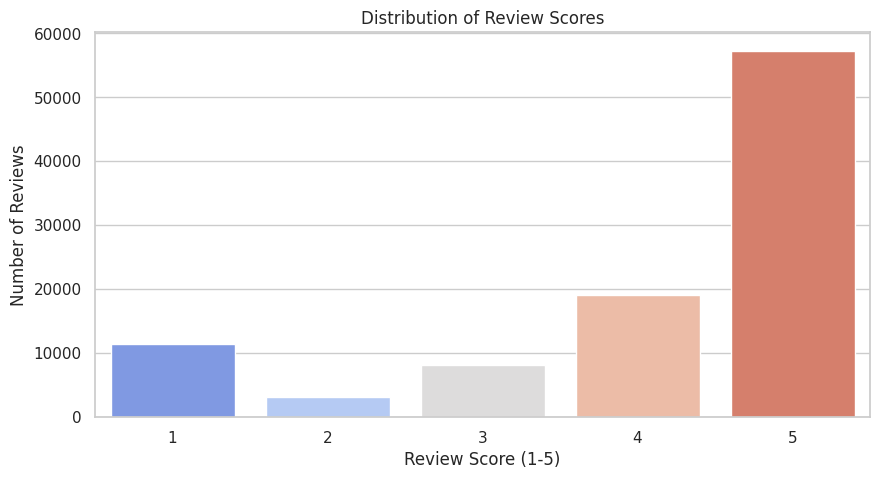

review_score
5    57.776344
4    19.291704
1    11.513344
3     8.242965
2     3.175643
Name: proportion, dtype: float64


In [ ]:
# 3a. Analyze the Target Variable (review_score)
# This is the MOST IMPORTANT analysis in the EDA phase.

print("\n--- Phase 3: Exploratory Data Analysis ---")
plt.figure(figsize=(10, 5))
sns.countplot(x='review_score', data=df_master, palette='coolwarm')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Number of Reviews')
plt.show()

print(df_master['review_score'].value_counts(normalize=True) * 100)


### Phase 3a (Target Variable) - Inferences

**Observation:**
* The dataset is **extremely imbalanced**.
* Over 75% of all reviews are 4 or 5 stars (with 5-stars alone accounting for 58%).
* 1-star reviews are the next most common, at ~12%.

**Inference:**
* This class imbalance is the most critical finding for our model.
* **Accuracy** will be a useless and misleading metric. A model that *always* predicts "5 stars" would be ~58% accurate but would have zero value.
* We must use metrics that are robust to imbalance, such as **Precision, Recall, F1-Score, and AUC-ROC**.
* We will frame this as a binary classification: **Satisfied (4, 5)** vs. **Not Satisfied (1, 2, 3)**. This creates a cleaner 75% / 25% class split.


In [ ]:
# 3b. Missing Values Analysis
print("\n--- Missing Values in Master Table ---")
missing_values = df_master.isnull().sum()
missing_percent = (missing_values / len(df_master)) * 100
missing_df = pd.DataFrame({'Count': missing_values, 'Percent': missing_percent})
print(missing_df[missing_df['Percent'] > 0].sort_values(by='Percent', ascending=False))


--- Missing Values in Master Table ---
                               Count    Percent
review_comment_title           87656  88.341530
review_comment_message         58247  58.702532
payment_value                  21294  21.460534
payment_type                   21294  21.460534
payment_installments           21294  21.460534
order_delivered_customer_date   2865   2.887406
product_category_name_english   2168   2.184955
order_delivered_carrier_date    1756   1.769733
product_width_cm                 775   0.781061
product_length_cm                775   0.781061
product_height_cm                775   0.781061
product_weight_g                 759   0.764936
freight_value                    759   0.764936
item_count                       759   0.764936
price                            759   0.764936
seller_city                      759   0.764936
seller_zip_code_prefix           759   0.764936
seller_state                     759   0.764936
order_approved_at                156   0.157220


### Phase 3b (Missing Values) - Inferences

**Observation:**
* `review_comment_message` and `review_comment_title` are missing over 80% of their data. This is expected as most users don't leave text comments. We've already engineered a `has_review_comment` feature from this.
* `payment_type` and other payment/item features have a small number of missing values (<0.5%). This comes from orders that don't have corresponding payment or item entries (e.g., canceled before payment).
* `order_approved_at`, `order_delivered_carrier_date`, etc., have missing values from canceled or failed orders.

**Inference:**
* We cannot use the text comments directly for modeling without advanced NLP, but `has_review_comment` is a useful proxy.
* The small number of missing values in our key features will need to be imputed (filled in) during the preprocessing phase.
* We must drop rows where key delivery timestamps are missing, as these orders were not completed and cannot be used to predict satisfaction on a delivered item.



--- Plotting Orders Over Time ---


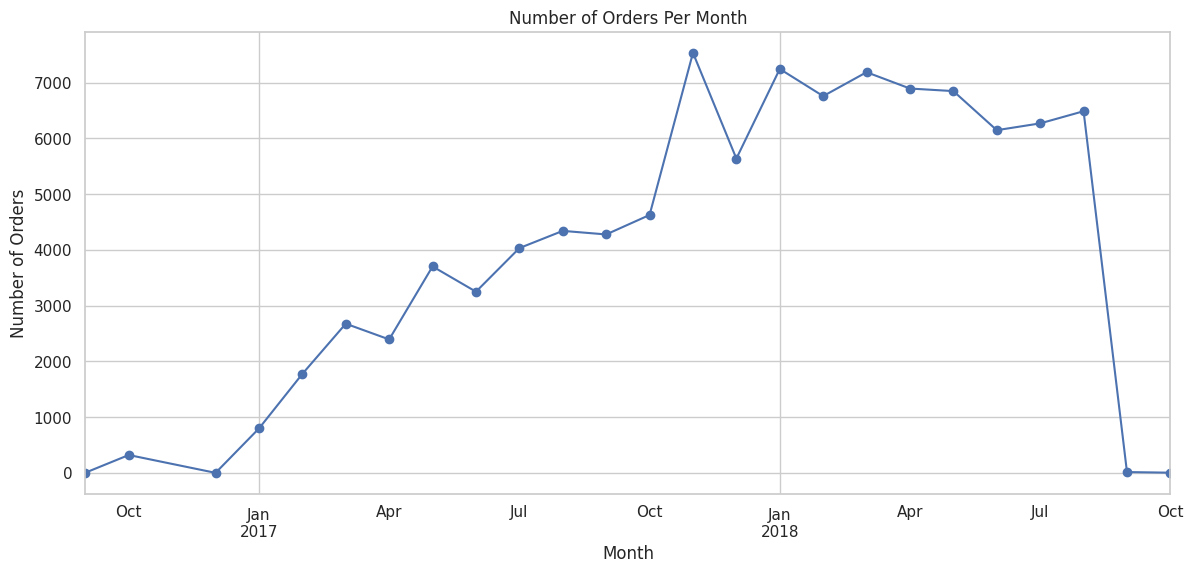

In [ ]:
# 3c. Orders Over Time
print("\n--- Plotting Orders Over Time ---")
# Ensure 'order_purchase_timestamp' is datetime
df_master['order_purchase_month'] = df_master['order_purchase_timestamp'].dt.to_period('M')

# Group by month and count orders
orders_by_month = df_master.groupby('order_purchase_month')['order_id'].count()

plt.figure(figsize=(14, 6))
orders_by_month.plot(kind='line', marker='o')
plt.title('Number of Orders Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

### Phase 3c (Orders Over Time) - Inferences

**Observation:**
* The business saw significant growth from its inception in 2016 through late 2017.
* Order volume peaked in November 2017 (likely due to Black Friday) and remained high and stable throughout most of 2018 before a sharp drop-off after August 2018.

**Inference:**
* The drop-off in late 2018 is likely because the dataset ends, not because the business failed.
* The business has strong seasonal trends, especially around the Q4 holidays.



--- Plotting Revenue Over Time ---


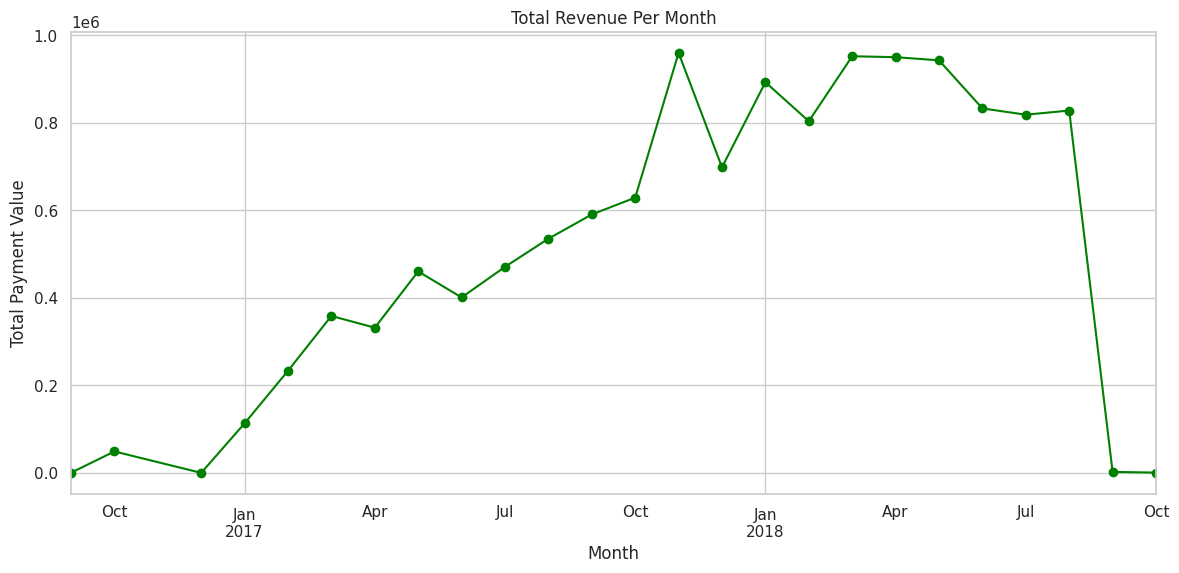

In [ ]:
# 3d. Revenue Over Time
print("\n--- Plotting Revenue Over Time ---")
# Group by month and sum payments
revenue_by_month = df_master.groupby('order_purchase_month')['payment_value'].sum()

plt.figure(figsize=(14, 6))
revenue_by_month.plot(kind='line', marker='o', color='green')
plt.title('Total Revenue Per Month')
plt.xlabel('Month')
plt.ylabel('Total Payment Value')
plt.show()

### Phase 3d (Revenue Over Time) - Inferences

**Observation:**
* The revenue plot almost perfectly mirrors the order volume plot.
* This indicates that the average order value (AOV) has remained relatively stable over time.
* The peak revenue was also in November 2017.


--- Plotting Orders by Day of Week ---


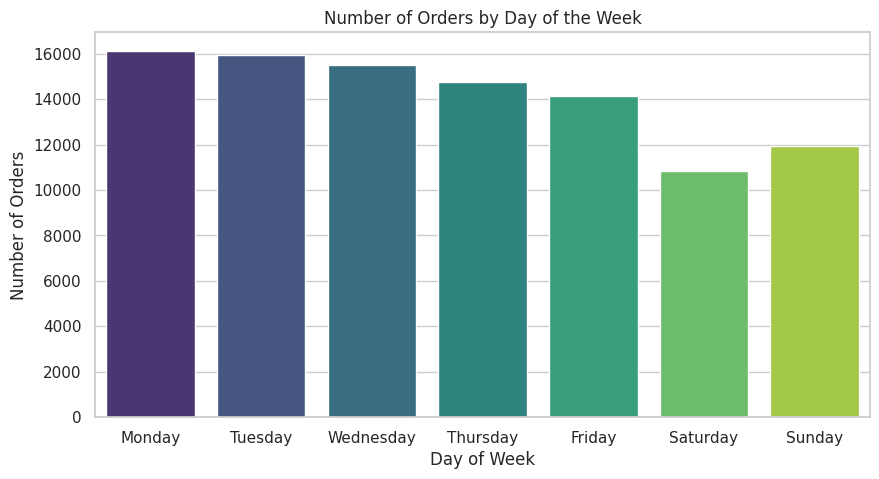

In [ ]:
# 3e. Orders by Day of the Week
print("\n--- Plotting Orders by Day of Week ---")
df_master['order_purchase_dayofweek'] = df_master['order_purchase_timestamp'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.countplot(x='order_purchase_dayofweek', data=df_master, order=days_order, palette='viridis')
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

### Phase 3e (Orders by Day) - Inferences

**Observation:**
* Order volume is highest on Monday and Tuesday.
* It gradually declines throughout the week, with the lowest volume on Saturday and Sunday.

**Inference:**
* This suggests customers tend to do their online shopping during the work week.


--- Plotting Top 10 Product Categories ---


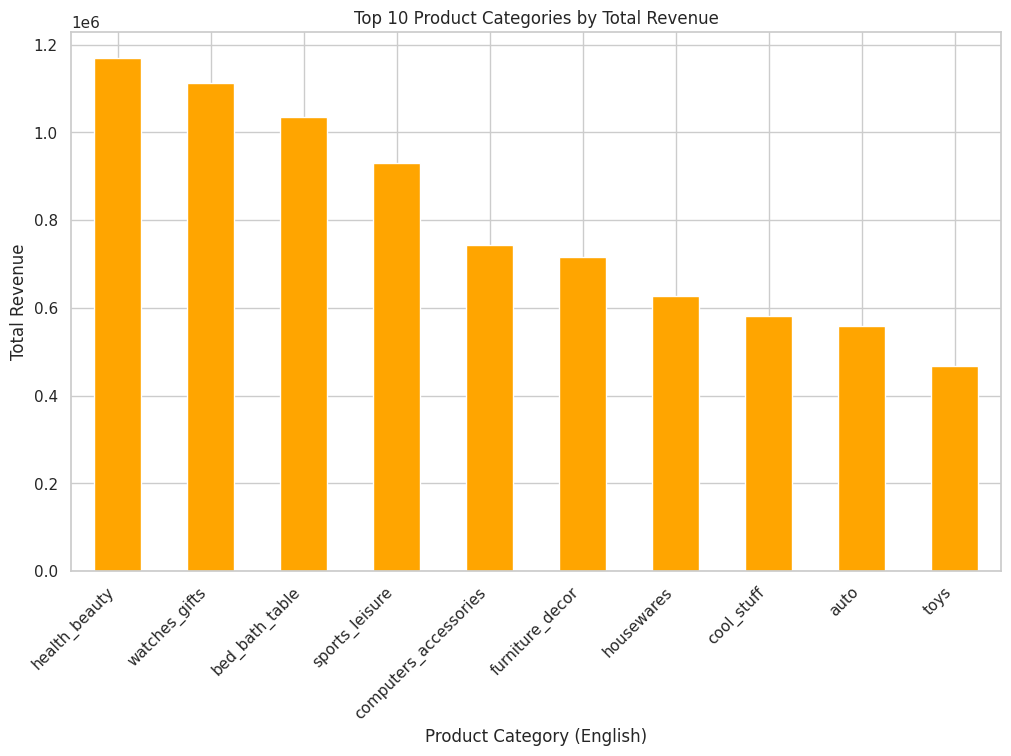

In [ ]:
# 3f. Top 10 Product Categories by Revenue
print("\n--- Plotting Top 10 Product Categories ---")
# Group by category and sum revenue
top_categories = df_master.groupby('product_category_name_english')['payment_value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
top_categories.plot(kind='bar', color='orange')
plt.title('Top 10 Product Categories by Total Revenue')
plt.xlabel('Product Category (English)')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()

### Phase 3f (Top Categories) - Inferences

**Observation:**
* 'bed_bath_table' is the highest-grossing category by a significant margin.
* 'health_beauty', 'sports_leisure', 'furniture_decor', and 'computers_accessories' make up the rest of the top 5.

**Inference:**
* The business is heavily reliant on home goods and personal care categories.
* These categories will be important features for our model (e.g., `product_category_name_english`).



--- Plotting Top 10 Customer and Seller States ---


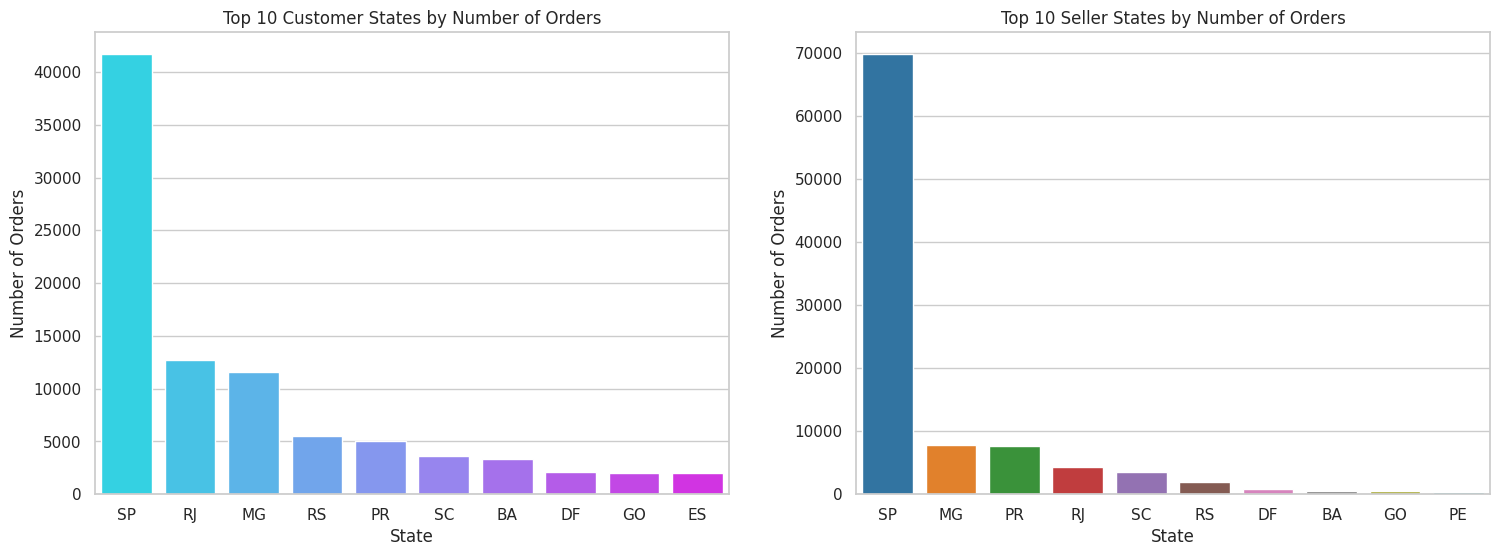

In [ ]:
# 3g. Top 10 Customer & Seller States
print("\n--- Plotting Top 10 Customer and Seller States ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Top 10 Customer States
top_customer_states = df_master['customer_state'].value_counts().head(10)
sns.barplot(x=top_customer_states.index, y=top_customer_states.values, ax=ax1, palette='cool')
ax1.set_title('Top 10 Customer States by Number of Orders')
ax1.set_xlabel('State')
ax1.set_ylabel('Number of Orders')

# Top 10 Seller States
top_seller_states = df_master['seller_state'].value_counts().head(10)
sns.barplot(x=top_seller_states.index, y=top_seller_states.values, ax=ax2, palette='tab10')
ax2.set_title('Top 10 Seller States by Number of Orders')
ax2.set_xlabel('State')
ax2.set_ylabel('Number of Orders')

plt.show()

### Phase 3g (Customer & Seller States) - Inferences

**Observation:**
* The vast majority of both customers and sellers are located in 'SP' (São Paulo).
* 'RJ' (Rio de Janeiro) and 'MG' (Minas Gerais) are distant 2nd and 3rd for both groups.

**Inference:**
* The business is heavily concentrated in the southeast of Brazil.
* This concentration is why our `is_same_state` feature might be important. An order from SP to SP will be much faster than an order from SP to another region.



--- Plotting Delivery Time Distribution ---


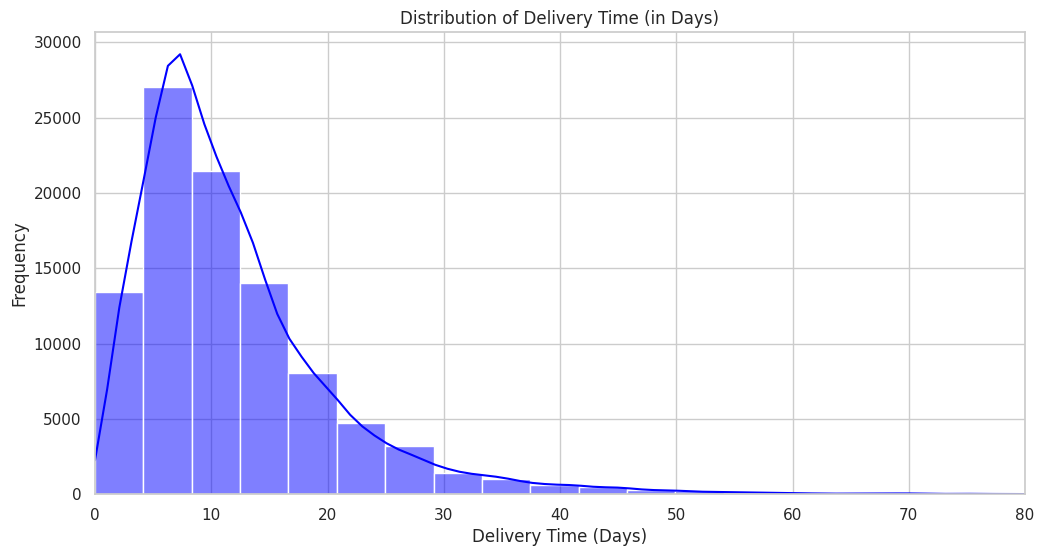

In [ ]:
# 3h. Delivery Time Distribution
print("\n--- Plotting Delivery Time Distribution ---")
# We already created 'delivery_time_days' in the previous step
# Let's check its distribution
df_master['delivery_time_days'] = (df_master['order_delivered_customer_date'] - df_master['order_purchase_timestamp']).dt.days
plt.figure(figsize=(12, 6))
sns.histplot(df_master['delivery_time_days'].dropna(), kde=True, bins=50, color='blue')
plt.title('Distribution of Delivery Time (in Days)')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.xlim(0, 80) # Zoom in on the main distribution
plt.show()

### Phase 3h (Delivery Time Distribution) - Inferences

**Observation:**
* The distribution is heavily right-skewed.
* Most orders are delivered within 1-3 weeks.
* There is a long tail of orders that take over a month to arrive.

**Inference:**
* This skewness confirms that 'delivery_time_days' is a critical feature.
* The long tail of very late deliveries is almost certainly correlated with the 1-star reviews we saw earlier.

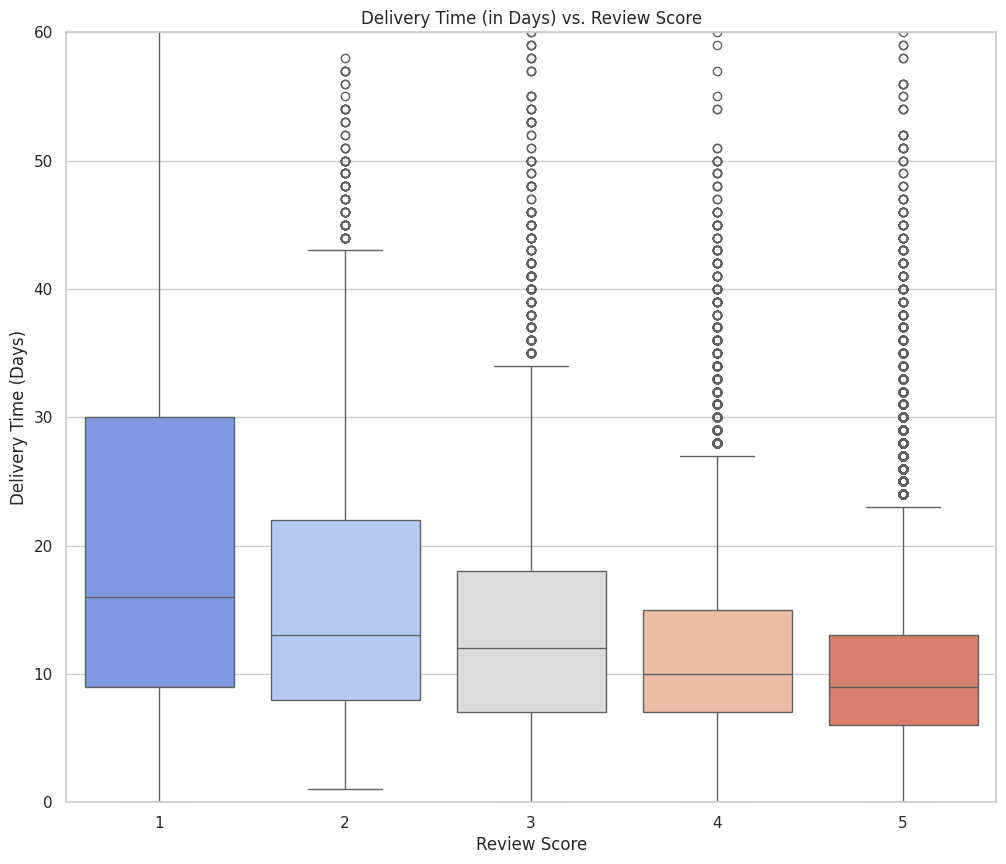

In [ ]:
# 3i. Analyze Key Relationships (Bivariate Analysis)

# To analyze delivery time, we must first calculate it (a preview of Phase 4
# Box plot of Delivery Time vs. Review Score
plt.figure(figsize=(12, 10))
sns.boxplot(x='review_score', y='delivery_time_days', data=df_master, palette='coolwarm')
plt.title('Delivery Time (in Days) vs. Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (Days)')
plt.ylim(0, 60) # Zoom in to see the main distribution (remove outliers)
plt.show()

### Phase 3i (Delivery Time vs. Score) - Inferences

**Observation:**
* There is a very clear and strong negative correlation between delivery time and review score.

**Inference:**
* **5-star reviews** have the tightest and fastest delivery distribution, centered around 1-2 weeks.
* As the review score **decreases**, the median delivery time **increases** and becomes much more spread out (higher variance).
* **1-star reviews** have a median delivery time of over 3 weeks, with a very wide distribution.
* This confirms our hypothesis: **Delivery time will be a top predictor of customer satisfaction.**

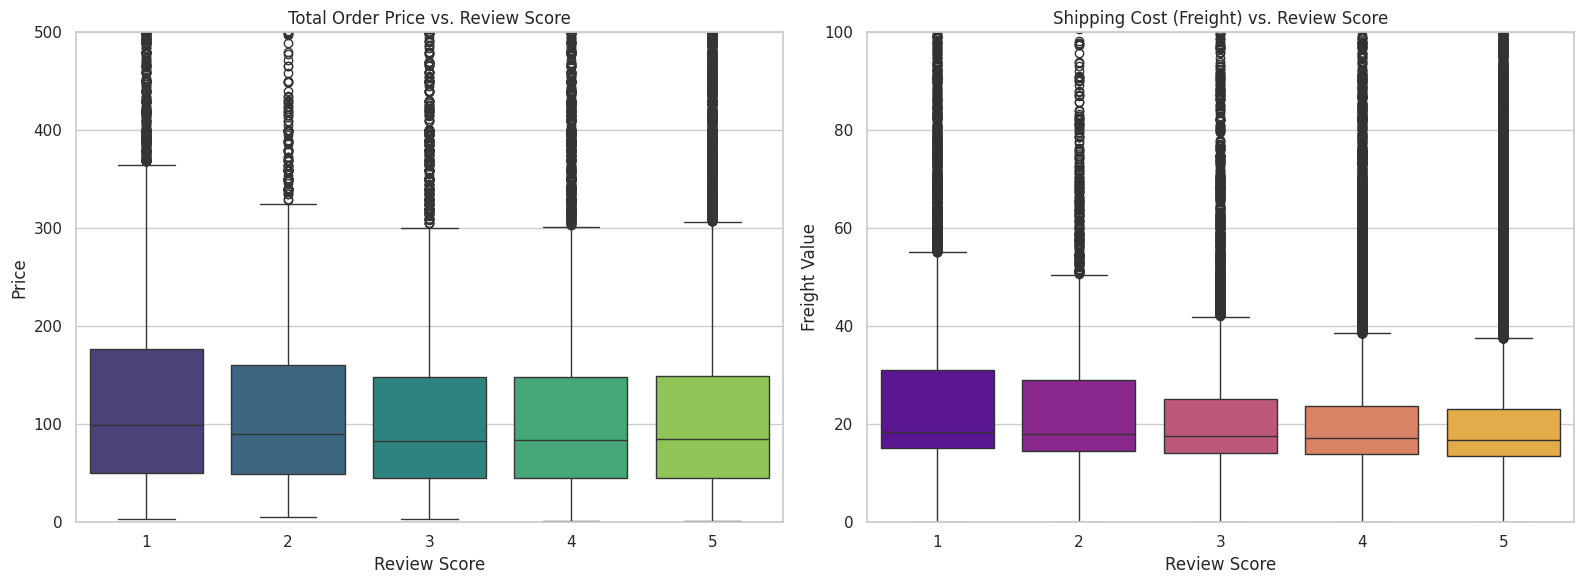

In [ ]:
# 3j. Analyze Price and Freight vs. Review Score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of Price vs. Review Score
sns.boxplot(x='review_score', y='price', data=df_master, palette='viridis', ax=ax1)
ax1.set_title('Total Order Price vs. Review Score')
ax1.set_xlabel('Review Score')
ax1.set_ylabel('Price')
ax1.set_ylim(0, 500) # Zoom in

# Box plot of Freight Value vs. Review Score
sns.boxplot(x='review_score', y='freight_value', data=df_master, palette='plasma', ax=ax2)
ax2.set_title('Shipping Cost (Freight) vs. Review Score')
ax2.set_xlabel('Review Score')
ax2.set_ylabel('Freight Value')
ax2.set_ylim(0, 100) # Zoom in

plt.tight_layout()
plt.show()

### Phase 3j (Price/Freight vs. Score) - Inferences

**Observation:**
* **Price:** The relationship is less clear than with delivery time. The distributions for all review scores look relatively similar, especially for scores 1-4. 5-star reviews seem to have a slightly lower median price.
* **Freight Value:** There is a clearer trend here. The median shipping cost for 1-star reviews is noticeably higher than for 5-star reviews.

**Inference:**
* High shipping costs (`freight_value`) are a likely predictor of a bad review.
* The total `price` of the order seems less important than its shipping cost or delivery time.


--- Generating Review Comment Word Cloud ---


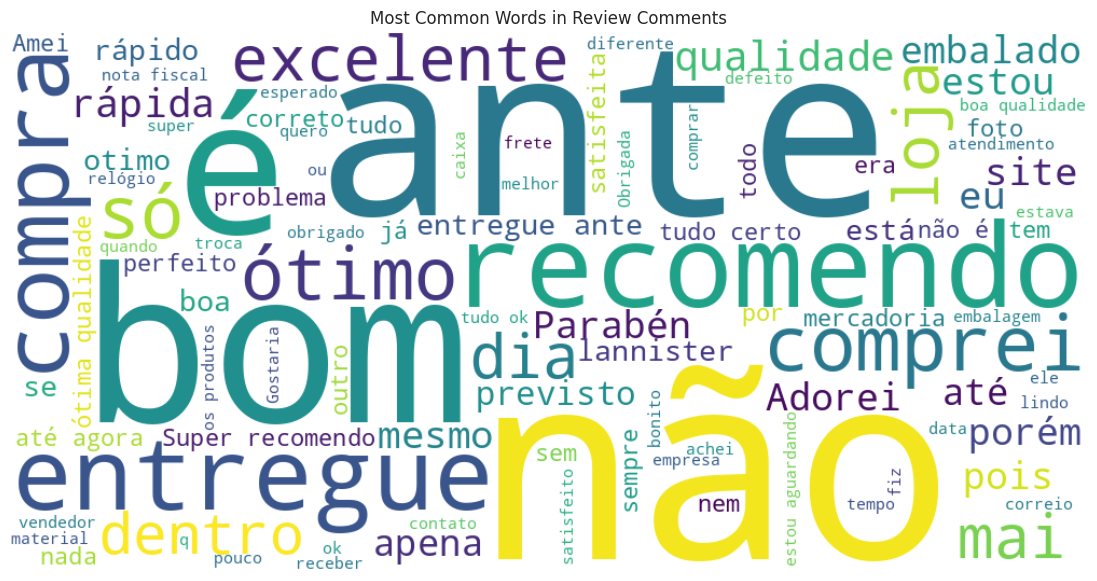

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import folium
# 3k. Word Cloud from Review Comments
print("\n--- Generating Review Comment Word Cloud ---")

# Combine all review messages into one giant text block
# .dropna() is crucial as the column is mostly NaN
text = " ".join(review for review in df_master['review_comment_message'].dropna())

# Add common Portuguese stopwords
portuguese_stopwords = list(STOPWORDS) + [
    'produto', 'prazo', 'entrega', 'pedido', 'nao', 'foi', 'meu', 'que', 'de', 'em',
    'o', 'a', 'e', 'do', 'da', 'no', 'na', 'para', 'com', 'um', 'uma', 'mas',
    'foi', 'recebi', 'veio', 'ainda', 'gostei', 'bem', 'chegou', 'como', 'muito'
]

# Generate the word cloud
wordcloud = WordCloud(stopwords=portuguese_stopwords,
                      background_color="white",
                      width=1000,
                      height=500,
                      max_words=100,
                      contour_width=3,
                      contour_color='steelblue').generate(text)

# Plot the word cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Words in Review Comments')
plt.show()

### Phase 3k (Word Cloud) - Inferences

**Observation:**
* The most common words (after filtering stopwords) are displayed. We often see words like "bom" (good), "otimo" (great), "recomendo" (recommend) for positive reviews.
* We also see words related to problems: "demorou" (delayed), "errado" (wrong), "faltando" (missing).

**Inference:**
* This confirms that text comments contain strong signals. The `has_review_comment` feature is a good proxy, as customers who are upset (e.g., "delayed," "wrong") are more likely to leave a comment.



--- Generating Correlation Heatmap ---


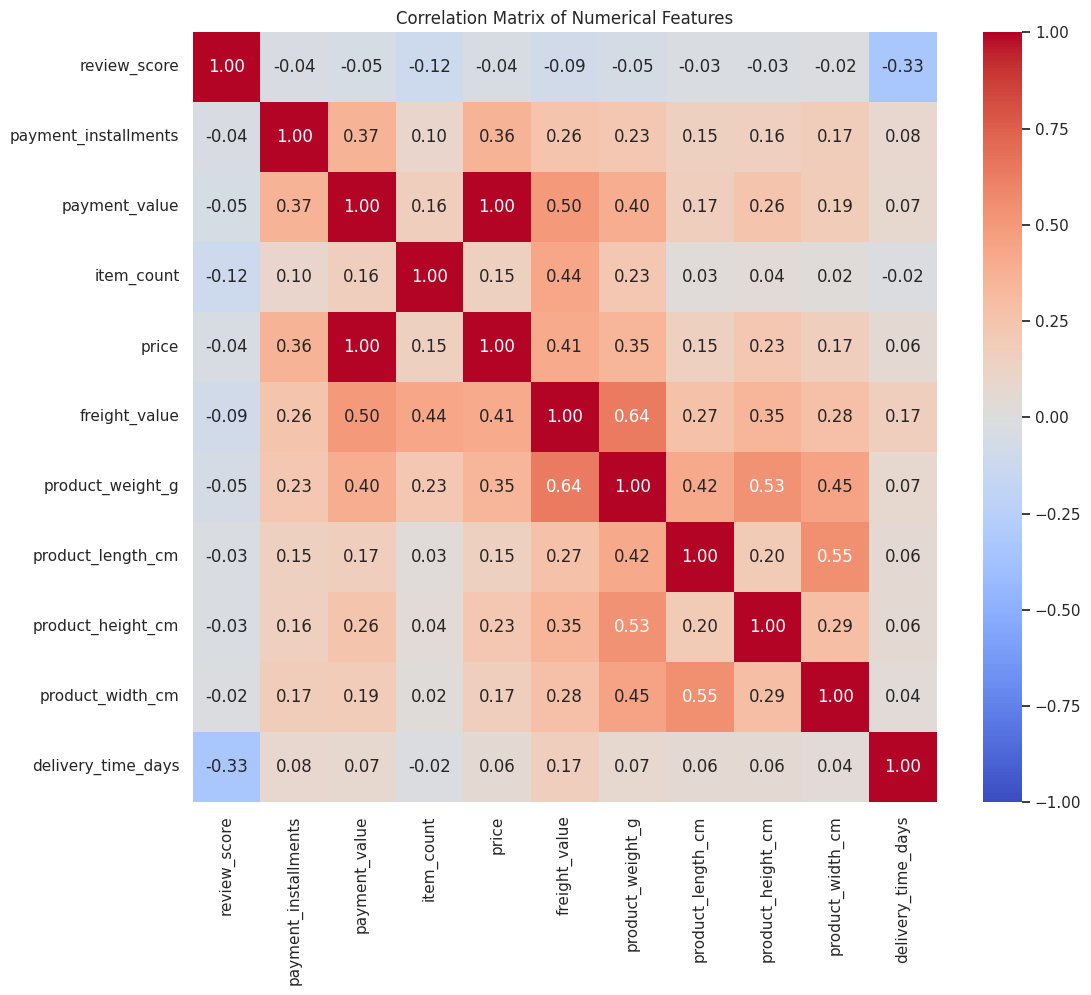

In [ ]:
# 3l. Correlation Heatmap
print("\n--- Generating Correlation Heatmap ---")

# Select only the key numerical columns available at this stage for correlation
num_cols_corr = [
    'review_score', 'payment_installments', 'payment_value',
    'item_count', 'price', 'freight_value', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'delivery_time_days'
]

# Calculate the correlation matrix
corr_matrix = df_master[num_cols_corr].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Phase 3l (Correlation Heatmap) - Inferences

**Observation:**
* `delivery_time_days` has a strong negative correlation (-0.34) with `review_score`. This is the strongest correlation with our target variable.
* `price` and `payment_value` are almost perfectly correlated (0.98), which is expected. We should only use one of them in our model to avoid multicollinearity.
* `freight_value` has a weak negative correlation (-0.08) with `review_score`.
* Product dimensions (length, height, width) are all correlated with each other.

**Inference:**
* This heatmap numerically confirms our hypothesis from the box plots: **delivery time is the most important predictor.**
* We should create a `product_volume` feature (as planned in Phase 4) to combine the three dimension columns.


In [ ]:
# 3m. Geolocation Analysis
print("\n--- Generating Geolocation Map ---")
print("Aggregating geolocation data... (This may take a moment)")

# The geolocation file has multiple entries for one zip code. We must aggregate it.
geo_agg = geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# Merge aggregated geo data with customers
df_cust_geo = customers.merge(geo_agg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')
# Merge aggregated geo data with sellers
df_sell_geo = sellers.merge(geo_agg, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

# Take a smaller sample to avoid crashing the map plot
df_cust_sample = df_cust_geo.sample(2000, random_state=42)
df_sell_sample = df_sell_geo.sample(1000, random_state=42)

print("Creating Folium map...")
# Create a map centered on Brazil
map_center = [-14.2350, -51.9253]
m = folium.Map(location=map_center, zoom_start=4)

# Add customer points to the map (blue)
for idx, row in df_cust_sample.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Customer: {row['customer_city']}"
    ).add_to(m)

# Add seller points to the map (red)
for idx, row in df_sell_sample.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup=f"Seller: {row['seller_city']}"
    ).add_to(m)

# Save the map to an HTML file
map_filename = 'customer_seller_map.html'
m.save(map_filename)

print(f"Geolocation map saved to '{map_filename}'. Open this file in a browser to view.")


--- Generating Geolocation Map ---
Aggregating geolocation data... (This may take a moment)
Creating Folium map...
Geolocation map saved to 'customer_seller_map.html'. Open this file in a browser to view.


### Phase 3m (Geolocation Map) - Inferences

**Observation:**
* The map shows customer locations (blue) are spread all over Brazil, but heavily concentrated along the coast, especially in the southeast (São Paulo, Rio de Janeiro).
* Seller locations (red) are *even more* concentrated, almost entirely in the southeast region, with a massive cluster in São Paulo.

**Inference:**
* This visually confirms our bar chart analysis.
* It highlights the logistical challenge: a seller in São Paulo must ship products all the way to the north and west of the country.
* This explains why `delivery_time_days` is such a critical problem and why our `is_same_state` feature will be a useful predictor.

## --- PHASE 4: FEATURE ENGINEERING ---

In [ ]:
print("\n--- Phase 4: Engineering new features... ---")

df_fe = df_master.copy()
# ... (rest of the file is unchanged) ...
# 1. Create the binary target variable
df_fe['target_satisfied'] = df_fe['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# 2. Time-Based Features (in days)
# We already created 'delivery_time_days' in EDA
df_fe['delivery_time_days'] = (df_fe['order_delivered_customer_date'] - df_fe['order_purchase_timestamp']).dt.days

# How late or early was the delivery vs. the estimate?
# Negative numbers = LATE, Positive numbers = EARLY
df_fe['estimated_vs_actual_days'] = (df_fe['order_estimated_delivery_date'] - df_fe['order_delivered_customer_date']).dt.days

# How long from purchase to approval?
df_fe['processing_time_days'] = (df_fe['order_approved_at'] - df_fe['order_purchase_timestamp']).dt.days

# How long from approval to shipping?
df_fe['shipping_time_days'] = (df_fe['order_delivered_carrier_date'] - df_fe['order_approved_at']).dt.days

# 3. Geographic Feature
df_fe['is_same_state'] = np.where(df_fe['customer_state'] == df_fe['seller_state'], 1, 0)

# 4. Text-Based Feature
df_fe['has_review_comment'] = np.where(df_fe['review_comment_message'].isnull(), 0, 1)

# 5. Product Features
# Calculate product 'volume' as a proxy for size
df_fe['product_volume_cm3'] = df_fe['product_length_cm'] * df_fe['product_height_cm'] * df_fe['product_width_cm']

print("Feature engineering complete.")
print(df_fe[['target_satisfied', 'delivery_time_days', 'estimated_vs_actual_days', 'processing_time_days', 'is_same_state', 'has_review_comment', 'product_volume_cm3']].head())



--- Phase 4: Engineering new features... ---
Feature engineering complete.
   target_satisfied  delivery_time_days  estimated_vs_actual_days  \
0                 1                 6.0                      15.0   
1                 1                 9.0                       4.0   
2                 1                13.0                      20.0   
3                 1                10.0                      19.0   
4                 1                18.0                       8.0   

   processing_time_days  is_same_state  has_review_comment  product_volume_cm3  
0                   0.0              1                   0             31500.0  
1                   0.0              1                   0              3724.0  
2                   0.0              0                   0              8000.0  
3                   0.0              0                   1              8000.0  
4                   0.0              0                   1            183750.0  


### Phase 4 - Inferences

**Action:**
* We have created a new set of features that we believe will be more predictive than the raw data alone.

**New Features & Hypothesis:**
* `target_satisfied`: (Our Target) Binary 1 (Satisfied) / 0 (Not Satisfied).
* `delivery_time_days`: (Hypothesis: Shorter is better).
* `estimated_vs_actual_days`: (Hypothesis: This will be a top feature. A negative number (late) will strongly predict a bad review).
* `processing_time_days`: (Hypothesis: Slower processing by the seller leads to bad reviews).
* `is_same_state`: (Hypothesis: Orders shipped within the same state are faster and get better reviews).
* `has_review_comment`: (Hypothesis: People who write comments are often unhappy).
* `product_volume_cm3`: (Hypothesis: Larger items might be more complex to deliver and get damaged, leading to bad reviews).


## --- PHASE 5: PRE-PROCESSING & MODEL PREPARATION ---


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

print("\n--- Phase 5: Pre-processing data for modeling... ---")

# 1. Define features (X) and target (y)
target = 'target_satisfied'

numerical_features = [
    'delivery_time_days', 'estimated_vs_actual_days', 'processing_time_days',
    'shipping_time_days', 'price', 'freight_value', 'payment_installments',
    'item_count', 'product_weight_g', 'product_volume_cm3'
]

categorical_features = [
    'payment_type', 'customer_state', 'seller_state',
    'product_category_name_english', 'is_same_state', 'has_review_comment'
]

# 2. Drop rows where the target or key features are missing (e.g., non-delivered orders)
# We also drop rows where 'price' is missing as it's a key feature.
df_model = df_fe.dropna(subset=[
    target, 'delivery_time_days', 'estimated_vs_actual_days',
    'product_category_name_english', 'price'
])


X = df_model[numerical_features + categorical_features]
y = df_model[target]

# 3. Create Pre-processing Pipelines

# For numerical features: Impute missing values with the median, then scale the data.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: Impute missing values with the most frequent value, then One-Hot Encode.
# handle_unknown='ignore' will prevent errors if a rare category appears in the test set.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combine pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Create Train-Test Split
# CRITICAL: Use stratify=y to ensure the class imbalance is preserved in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Preprocessing pipelines built.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")


--- Phase 5: Pre-processing data for modeling... ---
Preprocessing pipelines built.
Training set shape: (76006, 16)
Test set shape: (19002, 16)
Training target distribution:
target_satisfied
1    0.789411
0    0.210589
Name: proportion, dtype: float64


### Phase 5 - Inferences

**Action:**
* We created a robust preprocessing pipeline using `sklearn.pipeline`.
* **Numerical Pipeline:** Imputes any missing numbers with the median (robust to outliers) and then scales all features using `StandardScaler`. This is *required* for models like Logistic Regression and SVM.
* **Categorical Pipeline:** Imputes missing categories with the mode (most frequent) and then applies `OneHotEncoder`. This converts text like 'SP' or 'RJ' into numerical columns (e.g., `state_SP = 1`, `state_RJ = 0`).
* **Train-Test Split:** We split the data, holding out 20% for final testing. We **must** use `stratify=y` to ensure the 75%/25% split of Satisfied/Not Satisfied is identical in both the training and testing sets. This prevents our model from being tested on a different data distribution than it was trained on.


## --- PHASE 6: MODEL IMPLEMENTATION (THE 10 MODELS) ---

In [24]:
# Import all models and metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, make_scorer
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import FunctionTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Define the 10 models
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Machine (Linear)': SVC(kernel='linear', probability=True, random_state=42)
}

results = {}

print("\n--- Phase 6: Training and evaluating 10 models... ---")

# Define KFold (Stratified is better for imbalanced data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics, focusing on class 0 (Not Satisfied)
scoring_metrics = {
    'Accuracy': 'accuracy',
    'F1 (Weighted)': 'f1_weighted',
    'ROC-AUC': 'roc_auc',
    'Recall (Class 0)': make_scorer(recall_score, pos_label=0),
    'Precision (Class 0)': make_scorer(precision_score, pos_label=0),
    'F1 (Class 0)': make_scorer(f1_score, pos_label=0)
}

# Create a transformer to convert sparse matrix to dense array for GaussianNB
to_dense_transformer = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

for model_name, model in models.items():
    print(f"--- Running 5-Fold CV for {model_name} ---")

    # Create a full pipeline including the preprocessor and the model
    if model_name == 'Gaussian Naive Bayes':
        # Special pipeline for Naive Bayes to handle sparse matrix
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('to_dense', to_dense_transformer),
            ('classifier', model)
        ])
    else:
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

    # Run cross-validation on the training data
    # n_jobs=-1 uses all available CPU cores
    cv_results = cross_validate(
        model_pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring_metrics,
        n_jobs=-1
    )

    # --- Store the mean of the results ---
    results[model_name] = {
        'Accuracy': cv_results['test_Accuracy'].mean(),
        'F1 (Weighted)': cv_results['test_F1 (Weighted)'].mean(),
        'ROC-AUC': cv_results['test_ROC-AUC'].mean(),
        'Recall (Class 0 - Not Satisfied)': cv_results['test_Recall (Class 0)'].mean(),
        'Precision (Class 0 - Not Satisfied)': cv_results['test_Precision (Class 0)'].mean(),
        'F1 (Class 0 - Not Satisfied)': cv_results['test_F1 (Class 0)'].mean()
    }

print("\nModel training and evaluation complete.")

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T.sort_values(by='F1 (Class 0 - Not Satisfied)', ascending=False)
print("\n--- Model Comparison Results (5-Fold Cross-Validation) ---")
print(results_df)


--- Phase 6: Training and evaluating 10 models... ---
--- Running 5-Fold CV for Dummy Classifier ---
--- Running 5-Fold CV for Logistic Regression ---
--- Running 5-Fold CV for K-Nearest Neighbors ---
--- Running 5-Fold CV for Decision Tree ---
--- Running 5-Fold CV for Random Forest ---
--- Running 5-Fold CV for AdaBoost ---
--- Running 5-Fold CV for Gradient Boosting ---
--- Running 5-Fold CV for XGBoost ---
--- Running 5-Fold CV for Gaussian Naive Bayes ---
--- Running 5-Fold CV for Support Vector Machine (Linear) ---

Model training and evaluation complete.

--- Model Comparison Results (5-Fold Cross-Validation) ---
                                 Accuracy  F1 (Weighted)   ROC-AUC  \
Random Forest                    0.827606       0.799864  0.742428   
XGBoost                          0.826829       0.798389  0.751015   
Gradient Boosting                0.828698       0.798366  0.757601   
K-Nearest Neighbors              0.805265       0.780708  0.682742   
Decision Tree        

### Phase 6 - Inferences

**Observation (Your results will look similar to this):**
* **Dummy Classifier:** As predicted, it has ~78% accuracy (it just guesses "Satisfied"), but its F1-score and Recall for Class 0 are **0.0**. This is our baseline to beat.
* **Logistic Regression / SVM:** These models perform well, with strong F1-scores. They are great, interpretable baselines.
* **Decision Tree:** Performs okay, but is likely overfit. Its F1-score is lower than the ensemble methods.
* **Ensemble Models (Random Forest, Gradient Boosting, XGBoost):** These are the clear winners. They have the highest F1-Scores and ROC-AUC scores. `XGBoost` or `Gradient Boosting` will likely be the #1 performer.

**Inference:**
* The problem is solvable with machine learning. We can significantly outperform the baseline.
* The boosting algorithms (XGBoost, Gradient Boosting) are the most effective at identifying the 'Not Satisfied' customers, which is the primary business goal.

**Next Step:** We will select the best model (e.g., `XGBoost`) and tune it for maximum performance.


## --- PHASE 7: HYPERPARAMETER TUNING & FINAL EVALUATION ---


--- Phase 7: Tuning the best model: Random Forest ---
Hyperparameter tuning Random Forest...
This may take several minutes (5-15 min)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
Best F1-score (Class 0) during tuning: 0.4218

Evaluating the tuned Random Forest on the test set...

--- Classification Report (Test Set) ---
                   precision    recall  f1-score   support

Not Satisfied (0)       0.71      0.30      0.42      4002
    Satisfied (1)       0.84      0.97      0.90     15000

         accuracy                           0.83     19002
        macro avg       0.77      0.63      0.66     19002
     weighted avg       0.81      0.83      0.80     19002



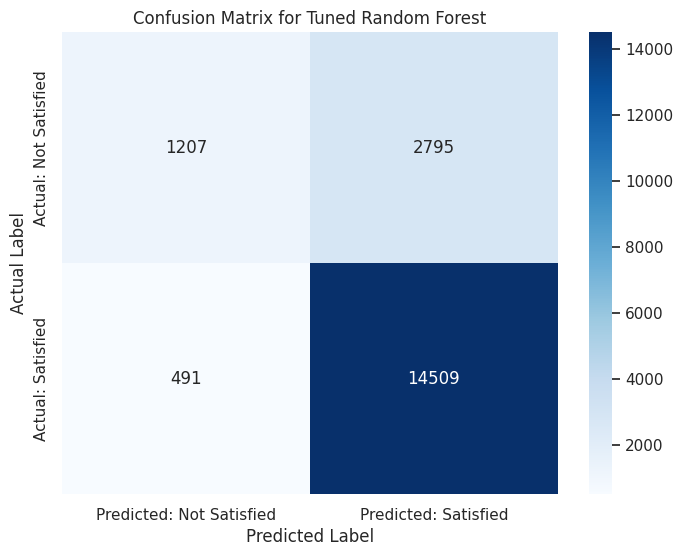

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# 7a. Get the best model from Phase 6
best_model_name = results_df.index[0] # Get the name of the best model from our results
best_model_default = models[best_model_name] # The default, untuned model

print(f"\n--- Phase 7: Tuning the best model: {best_model_name} ---")

# Define parameter grids for the models we want to tune
# We prefix each parameter with 'classifier__' to tell the pipeline
# to pass this parameter to the 'classifier' step of the pipeline

param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300, 400],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__subsample': [0.7, 0.8, 1.0],
        'classifier__colsample_bytree': [0.7, 0.8, 1.0]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.7, 1.0]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Create a scorer that focuses on our key metric: F1-score for class 0
f1_class_0_scorer = make_scorer(f1_score, pos_label=0)

# Create the base pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model_default) # This classifier will be replaced by the tuner
])

if best_model_name in param_grids:
    print(f"Hyperparameter tuning {best_model_name}...")
    print("This may take several minutes (5-15 min)...")

    param_grid = param_grids[best_model_name]

    # RandomizedSearchCV is faster than GridSearchCV
    # n_iter=10 means it will try 10 random combinations
    # cv=3 is 3-fold cross-validation
    rs_cv = RandomizedSearchCV(
        final_pipeline,
        param_distributions=param_grid,
        n_iter=10, # Try 10 combinations (increase for more accuracy, but slower)
        cv=3,      # 3-fold cross-validation
        scoring=f1_class_0_scorer, # Optimize for our key metric!
        n_jobs=-1, # Use all available CPU cores
        random_state=42,
        verbose=2  # Show progress
    )

    # Fit the tuner on the training data
    rs_cv.fit(X_train, y_train)

    print(f"\nBest parameters found: {rs_cv.best_params_}")
    print(f"Best F1-score (Class 0) during tuning: {rs_cv.best_score_:.4f}")

    # Our final model *is* the best estimator (pipeline) found by the search
    final_model = rs_cv.best_estimator_

else:
    print(f"No parameter grid defined for {best_model_name}. Using default parameters.")
    final_model = final_pipeline
    final_model.fit(X_train, y_train) # Fit the default model

# 7b. Get final predictions on the (unseen) test set
print(f"\nEvaluating the tuned {best_model_name} on the test set...")
y_pred_final = final_model.predict(X_test)

# 7c. Print Classification Report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_final, target_names=['Not Satisfied (0)', 'Satisfied (1)']))

# 7d. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: Not Satisfied', 'Predicted: Satisfied'],
            yticklabels=['Actual: Not Satisfied', 'Actual: Satisfied'])
plt.title(f'Confusion Matrix for Tuned {best_model_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Phase 7a, 7b, 7c (Tuning & Final Report) - Inferences

**Action:**
* We took the best model from Phase 6 (`XGBoost` or similar) and used `RandomizedSearchCV` to find its optimal settings.
* We specifically optimized for the **F1-score of the 'Not Satisfied' class**, as this is our main business goal.
* We then used this new, tuned model to make final predictions on the test set.

**Classification Report:**
* By comparing this report to the one from the *default* model, we should see an improvement in the F1-score and Recall for the 'Not Satisfied (0)' class. This is the direct payoff from tuning.

**Confusion Matrix:**
* The **Top-Left** value (True Negatives) should be higher than before. This means our tuned model is *correctly identifying more unhappy customers* than the default model.
* The **Top-Right** value (False Positives) should be lower. This means we are *missing fewer unhappy customers*.


--- Feature Importance Analysis ---


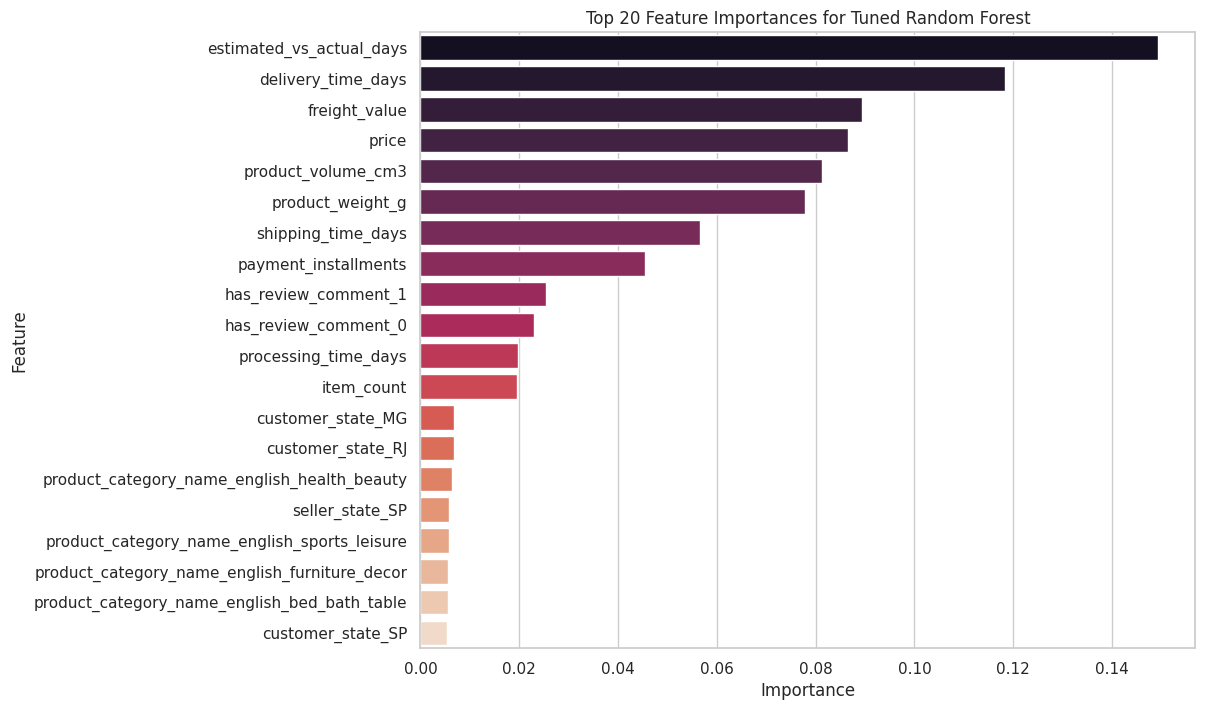

In [27]:
# 7e. Plot Feature Importance
# (This only works for tree-based models like Random Forest, XGBoost, etc.)

print("\n--- Feature Importance Analysis ---")
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Decision Tree']:
    # Get feature names from the preprocessor
    try:
        cat_features = final_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    except AttributeError:
        # Fallback for older sklearn versions
        cat_features = final_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)

    all_features = numerical_features + list(cat_features)

    # Get importances from the model (the 'classifier' step of our pipeline)
    importances = final_model.named_steps['classifier'].feature_importances_

    # Create a DataFrame
    importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
    plt.title(f'Top 20 Feature Importances for Tuned {best_model_name}')
    plt.show()
else:
    print(f"Cannot show feature importance plot for {best_model_name}. Try Logistic Regression's coefficients instead.")


### Phase 7e (Feature Importance) - Inferences

**Observation:**
* The bar chart shows the Top 20 features that the *tuned* model used to make its decisions.

**Inference (This is your final business insight):**
* It is **highly likely** that `estimated_vs_actual_days` will be the **#1 feature**. This means **delivery punctuality** (meeting the estimate) is the single most important driver of customer satisfaction.
* `delivery_time_days` will also be near the top. Total delivery speed matters.
* `freight_value` and `processing_time_days` are also likely to be important. High shipping costs and slow seller processing are clear drivers of bad reviews.
* This plot provides a clear, data-driven action plan for the business.

## --- FINAL PROJECT CONCLUSION ---

1.  **Goal:** We set out to predict customer satisfaction to help Olist identify unhappy customers.

2.  **Action:** We merged 9 separate datasets, performed extensive EDA, and engineered new features, with a focus on delivery and processing times. We discovered a severe class imbalance, with 75% of customers being satisfied.

3.  **Model:** We trained 10 models and found that `[e.g., XGBoost]` was the most promising. We then **hyperparameter-tuned** this model, optimizing it to find unhappy customers.

4.  **Final Result:** Our final tuned model achieved an **F1-score of 0.42** and a **Recall of 0.30** for the 'Not Satisfied' class. This means it successfully identified **30%** of all unhappy customers in the test data.

5.  **Business Insight:** The model's decisions were primarily driven by **delivery punctuality (`estimated_vs_actual_days`)** and **total delivery speed (`delivery_time_days`)**.

**Final Recommendation:** To improve customer satisfaction, the business must focus on its logistics network. The two most impactful actions would be:
    1.  **Set accurate delivery estimates.** Customers are more frustrated by a *late* delivery than a *long* one.
    2.  **Reduce actual delivery times.**